# Feature selection

**Imports and random seeds**

In [1]:
# Imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

import os
import pickle


In [2]:
# Seeds

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


**Binary Classification model**

In [3]:
class ClassificationModel():

    def __init__(self, target_label):

        set_seed(42)
        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.target_label = target_label
        self.dataset = self.load_dataset()
        self.x_train, self.x_test, self.y_train, self.y_test = self.create_train_test_data()
        self.measures = {}
        self.classifiers = {}
        self.feature_importances = pd.Series()
        self.run(self.all_features)

    def load_dataset(self):

        dataset = pd.read_csv("../dataset/train_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)

        return dataset
    
    def balanced_sampling(self, target_class_df):

        target_class_df = target_class_df.sort_values(by = "target_label", ascending = False)
        number_of_defects = target_class_df["target_label"].sum()
        target_class_df_1 = target_class_df.iloc[:number_of_defects, :]
        negative_samples = random.sample(range(number_of_defects, len(target_class_df)), number_of_defects)
        target_class_df_0 = target_class_df.iloc[negative_samples, :]
        df = pd.concat([target_class_df_1, target_class_df_0], ignore_index=True)

        return df

    def create_train_test_data(self):

        # Create target labels:
        target_class_df = self.dataset.copy()
        target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == self.target_label else 0)

        # Apply train test split:
        df = self.balanced_sampling(target_class_df)
        x = df.loc[:, self.all_features]
        y = df.loc[:, "target_label"]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        return x_train, x_test, y_train, y_test

    def select_features(self, features):

        x_train = self.x_train.loc[:, features]
        x_test = self.x_test.loc[:, features]

        return x_train, x_test
    
    def evaluate(self, y_pred, y_test):

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average=None)[1]
        f1 = f1_score(y_test, y_pred, average=None)[1]

        return accuracy, recall, f1
    
    def run(self, features, number_of_forests=1):

        # Check whether feature combination already exists in measures dictionary:
        feature_combination = ", ".join(sorted(features))
        if feature_combination in self.measures:
            accuracy, recall, f1 = self.measures[feature_combination]
            current_feature_importances = self.feature_importances
            clf = self.classifiers[feature_combination]
        else:

            # Generate train dataset with selected features: 
            x_train, x_test = self.select_features(features)

            # Perform the random forest classifier: 
            for i in range(number_of_forests):
                clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=i, max_depth=10)
                clf.fit(x_train, self.y_train)
                y_pred = clf.predict(x_test)
                if i == 0:
                    y_pred_final = y_pred
                else:
                    y_pred_final = np.array([1 if y_pred[i] == 1 or y_pred_final[i] == 1 else 0 for i in range(len(y_pred))])

            # Evaluate and store results:
            accuracy, recall, f1 = self.evaluate(y_pred_final, self.y_test)
            current_feature_importances = clf.feature_importances_
            feature_names = x_train.columns
            current_feature_importances = pd.Series(current_feature_importances, index=feature_names)
            
            self.measures[feature_combination] = (accuracy, recall, f1)
            self.classifiers[feature_combination] = clf
            for feature in current_feature_importances.index:
                self.feature_importances.loc[feature] = current_feature_importances.loc[feature]

        print(f"Feature set: {features}, \nAccuracy: {accuracy}, \nRecall: {recall},\nF1: {f1}\n")
        return accuracy, recall, f1, current_feature_importances, clf
    
    def test(self, features, clf):

        # Load and prepare validation dataset
        df = pd.read_csv("../dataset/validation_0_975_all_defects.csv", sep = ",")
        df.drop(columns = ["image_number", "defect_number"], inplace = True)
        labels = df["label"]
        df.dropna(inplace = True)
        df["target_label"] = df["label"].apply(lambda x: 1 if x == self.target_label else 0)
        x_test, y_test = df.loc[:, self.all_features], df.loc[:, "target_label"]
        x_test = x_test.loc[:, features]

        # Test and evaluate
        y_pred = clf.predict(x_test)
        y_probas = clf.predict_proba(x_test)[:, 1]
        accuracy, recall, f1 = self.evaluate(y_pred, y_test)

        return accuracy, recall, f1, y_probas, labels



**Environment**

In [4]:
class State():

    def __init__(self, state, action=None):

        if not action == None:
            state = self.bitflip(state, action)

        self.binary = state.float()

    def bitflip(self, state, action):

        adjusted_state = state.binary.clone()

        for index in action:
            if state.binary[index] == 0:
                adjusted_state[index] = 1
            else:
                adjusted_state[index] = 0

        return adjusted_state


class Dacl10kEnvironment():

    def __init__(self, classifier, initial_state=None):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.classifier = classifier
        self.features_dict = {i: feature for i, feature in enumerate(self.all_features)}
        self.statesize = len(self.all_features)

        _, _, _, current_feature_importances, _ = self.classifier.run(self.all_features)
        self.feature_importances = current_feature_importances

        self.initial_state = State(torch.FloatTensor([i % 2 for i in range(len(self.all_features))])) if initial_state == None else initial_state
        self.state = self.initial_state

        self.accuracies = {}
        self.recalls = {}
        self.f1_scores = {}
        self.classifiers = {}

    def step(self, action):

        next_state = State(self.state, action)
        self.state = next_state

        features_indices = [i for i, value in enumerate(self.state.binary.numpy()) if value == 1]
        features = [self.features_dict[i] for i in features_indices]
        accuracy, recall, f1, current_feature_importances, clf = self.classifier.run(features)
        reward = f1
        self.accuracies[tuple(features)] = accuracy
        self.recalls[tuple(features)] = recall
        self.f1_scores[tuple(features)] = f1
        self.classifiers[tuple(features)] = clf
        for feature in current_feature_importances.index:
            self.feature_importances.loc[feature] = current_feature_importances.loc[feature]

        return next_state, reward


**Reinforcement Agent**

In [5]:
class FeedforwardNet(nn.Module):

    def __init__(self, env, device, hidden_size):

        super(FeedforwardNet, self).__init__()
        
        self.device = device
        self.statesize = env.statesize
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(self.statesize, self.hidden_size).to(self.device)
        self.output_layer = nn.Linear(self.hidden_size, self.statesize).to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)

    def forward(self, input):

        x = self.hidden_layer(input)
        x = torch.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x


class ReinforcementAgent():

    def __init__(self, env):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = FeedforwardNet(env, self.device, 50)

        self.optimizer = torch.optim.Adam(self.net.parameters(),lr=0.01)

        self.exploration_chance = 0.05
        self.statesize = env.statesize

    def step(self, state, feature_importances):

        probabilities = self.net.forward(feature_importances)
        #print(probabilities)
        probability_differences = torch.abs(state.binary - probabilities)
        _, action = torch.topk(probability_differences, random.randint(5, 15))
        action = action.tolist()

        """
        # Exploration adjustments:
        for i, _ in enumerate(action):
            if random.random() < self.exploration_chance:
                action[i] = random.randint(0, self.statesize - 1)
        """

        # Exploration adjustements:
        for i in range(self.statesize):
            if random.random() < self.exploration_chance and i not in action:
                action.append(i)

        # If no feature remaining in action, include highest likelihood features
        if torch.sum(State(state, action).binary).item() < 1:
            action = None

        return action

    def update(self, reward):

        reward = torch.tensor(reward, dtype=torch.float32, requires_grad=True)
        #loss = -torch.log(reward)
        loss = torch.sqrt(1 - reward)
        #print(f"Loss: {loss}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



**Train the reinforcement agent**

In [6]:
def plot_rewards(rewards, directory=None):

    x = list(range(len(rewards)))

    moving_average_rewards = []
    window_size = 50
    for i in range(len(rewards)):
        start_index = max(0, i - window_size + 1)
        window = rewards[start_index:i + 1]
        moving_average_rewards.append(sum(window) / len(window))

    plt.figure(figsize=(10, 5))
    plt.plot(x, rewards, marker="o", linestyle="-", color="b")
    plt.plot(x, moving_average_rewards, linestyle="-", color="r")

    plt.title("Rewards")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.grid(True)

    if not directory == None:
        os.makedirs(os.path.dirname(directory), exist_ok=True)
        plt.savefig(directory)
    plt.show()

def train_agent(classifier, initial_features=None, epochs=500, directory=None):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    agent = ReinforcementAgent(env)

    state = env.initial_state
    rewards = []

    # Prepare initial state:
    if not initial_features == None:
        initial_state = State(torch.FloatTensor([feature in initial_features for feature in env.all_features]))
        env = Dacl10kEnvironment(classifier, initial_state=initial_state)

    # Run epochs:
    for i in range(epochs): 

        print(f"Epoch {i}")
        
        action = agent.step(state, torch.FloatTensor(env.feature_importances.loc[:]))
        #print(action)
        next_state, reward = env.step(action)
        agent.update(reward)
        state = next_state

        print(f"Reward: {reward}\n")
        rewards.append(reward)

    # Evaluate results:
    plot_rewards(rewards, directory)

    best_feature_set = max(env.f1_scores, key=lambda k: env.f1_scores[k])
    best_f1_score = env.f1_scores[best_feature_set]
    accuracy = env.accuracies[best_feature_set]
    recall = env.recalls[best_feature_set]
    best_classifier = env.classifiers[best_feature_set]
    print(f"Best dev parameter list: {best_feature_set}\nReward: {best_f1_score}\n")

    return best_feature_set, best_f1_score, accuracy, recall, best_classifier

def random_monkey(classifier, repetitions=500):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    rewards = []

    # Run repetitions:
    for i in range(repetitions):

        print(f"Repitition {i}")
        
        random_binary = random.choices([0, 1], k=44)
        features_indices = [i for i, value in enumerate(random_binary) if value == 1]
        features = [env.features_dict[i] for i in features_indices]
        reward = classifier.run(features)
        rewards.append(reward)
        env.table[tuple([env.features_dict[i] for i, binary in enumerate(random_binary) if binary == 1])] = reward
    
    # Evaluate results:
    plot_rewards(rewards)
    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}\n")


**Cross-evaluation of the classifiers**

In [7]:
class CrossClassificationModel():

    def __init__(self, relevant_features):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.relevant_features = relevant_features
        self.classifiers = self.load_classifiers()
        self.predictions, self.labels = self.predict_binary()

        self.results = pd.concat([self.predictions.reset_index(drop=True), 
                                  self.predict_label().reset_index(drop=True), 
                                  self.labels.reset_index(drop=True)], axis=1)

    def load_classifiers(self):

        classifiers = {}

        for defect in self.relevant_features.keys():
            try:
                with open(f"classifiers/resulting_classifier_{defect}.pkl", "rb") as f:
                    clf = pickle.load(f)
            except:
                try:
                    results = pd.read_csv(f"results/results_feature_selection_{defect}.csv")
                    feature_set = results.loc[0, "Best dev feature set"]
                    feature_set = [int(x) for x in feature_set.strip("()").replace("'", "").split(", ")]
                except:
                    feature_set = self.all_features
                defect_classifier = ClassificationModel(defect)
                _, _, _, _, clf = defect_classifier.run(feature_set)
            classifiers[defect] = clf
        
        return classifiers

    def predict_binary(self):

        predictions = {}
        
        for defect in self.relevant_features.keys():
            classifier = ClassificationModel(defect)
            _, _, _, probs, labels = classifier.test(self.relevant_features[defect], self.classifiers[defect])
            predictions[defect] = probs

        predictions = pd.DataFrame(predictions)
        return predictions, labels
    
    def predict_label(self):

        predicted_labels = {}

        for i in range(len(self.predictions)):
            count = 0
            max = 0
            max_label = None
            for j in range(self.predictions.shape[1]):
                if self.predictions.iloc[i, j] >= 0.5:
                    count += 1
                    if self.predictions.iloc[i, j] > max:
                        max = self.predictions.iloc[i, j]
                        max_label = self.predictions.columns[j]
            predicted_labels[i] = [count, max, max_label if not max_label == None else "Nothing"]
        
        predicted_labels = pd.DataFrame(predicted_labels).T
        predicted_labels.columns = ["Count", "Max", "Predicted Label"]

        return predicted_labels
    
    def evaluate_results(self, variant):

        y_true = self.results["label"]
        y_pred = self.results["Predicted Label"]

        for i, _ in enumerate(y_true):
            if y_true.iloc[i] not in self.relevant_features.keys():
                y_true.iloc[i] = "Nothing"

        accuracy = accuracy_score(y_true, y_pred)
        
        recall_micro = recall_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        # Save results:
        df = pd.DataFrame({"Accuracy": [accuracy], "Recall (Micro)": [recall_micro], "Recall (Macro)": [recall_macro], 
                           "Recall (Weighted)": [recall_weighted], "F1 Score (Micro)": [f1_micro], "F1 Score (Macro)": [f1_macro], 
                           "F1 Score (Weighted)": [f1_weighted]})
        os.makedirs(os.path.dirname(f"results/results_cross_classification_{variant}.csv"), exist_ok=True)
        df.to_csv(f"results/results_cross_classification_{variant}.csv")
        print(f'Accuracy: {accuracy}')
        print(f'Recall (Micro): {recall_micro}')
        print(f'Recall (Macro): {recall_macro}')
        print(f'Recall (Weighted): {recall_weighted}')
        print(f'F1 Score (Micro): {f1_micro}')
        print(f'F1 Score (Macro): {f1_macro}')
        print(f'F1 Score (Weighted): {f1_weighted}')

        cm = confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true))))
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

        # Compute confusion matrix
        labels = sorted(list(set(y_true)))  # Get unique labels and sort them

        # Plotting the confusion matrix as a heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')

        # Save the plot
        os.makedirs(os.path.dirname(f"results/results_cross_classification_{variant}.png"), exist_ok=True)
        plt.savefig(f"results/results_cross_classification_{variant}.png")
        plt.show()


# Feature selection experiments

**General experiment**

In [8]:
def feature_selection_experiment(defect_type, hypothesized_features, epochs): 

    all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                    "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                    "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                    "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                    "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                    "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

    # Perform classification with hypothesized features
    defect_classifier = ClassificationModel(defect_type)
    _, _, _, _, initial_clf = defect_classifier.run(hypothesized_features)
    initial_accuracy, initial_recall, initial_f1, _, _ = defect_classifier.test(hypothesized_features, initial_clf)

    # Perform classification with all features
    _, _, _, _, all_features_clf = defect_classifier.run(all_features)
    all_accuracy, all_recall, all_f1, _, _ = defect_classifier.test(all_features, all_features_clf)

    # Perform reinforcement learning 
    best_dev_feature_set, best_dev_f1_score, dev_accuracy, dev_recall, best_dev_clf = train_agent(
        defect_classifier, initial_features=hypothesized_features, epochs=epochs, 
        directory=f"results/results_feature_selection_{defect_type}.png")
    test_accuracy, test_recall, test_f1, _, _ = defect_classifier.test(best_dev_feature_set, best_dev_clf)

    # Save results
    df = pd.DataFrame({"Defect": [defect_type], "All features f1 score": [all_f1], "All features accuracy": [all_accuracy], 
                       "All features recall": [all_recall], "Initial f1 score": [initial_f1], "Initial accuracy": [initial_accuracy], 
                       "Initial recall": [initial_recall], "Best dev f1_score": [best_dev_f1_score], "Dev accuracy": [dev_accuracy], 
                       "Dev recall": [dev_recall], "Best dev feature set": [best_dev_feature_set], 
                       "Test accuracy": [test_accuracy], "Test recall": [test_recall], 
                       "Test f1": [test_f1]})
    df.to_csv(f"results/results_feature_selection_{defect_type}.csv")

    # Save best classifier
    os.makedirs(os.path.dirname(f"classifiers/resulting_classifier_{defect_type}.pkl"), exist_ok=True)
    with open(f"classifiers/resulting_classifier_{defect_type}.pkl", "wb") as f:
        pickle.dump(best_dev_clf, f)

**Feature selection rust**

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7917694404777359, 
Recall: 0.8266494178525227,
F1: 0.7993495121341007

Feature set: ['reddish', 'rough', 'darker'], 
Accuracy: 0.7638582370504998, 
Recall: 0.8134540750323416,
F1: 0.7756260022203033

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_b

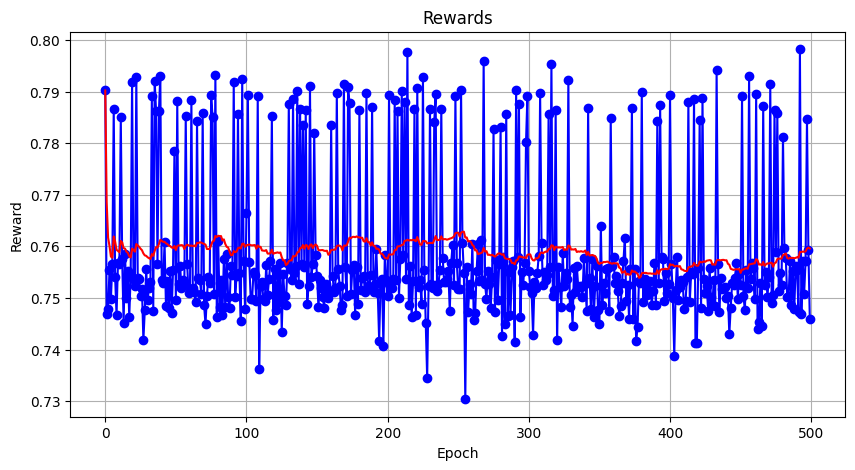

Best dev parameter list: ('gradient', 'reddish', 'colorful', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_8', 'rough', 'dominating_texture', 'texture_0', 'rough_entropy', 'number_lengthy_objects', 'rel_length', 'in_shape', 'roundness', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5')
Reward: 0.7982096232748974



In [9]:
hypothesized_features_rust = ["reddish", "rough", "darker"]

feature_selection_experiment("Rust", hypothesized_features_rust, epochs=500)


**Feature selection drainage**

In [10]:
hypothesized_features_drainage = ["black", "black_thin", "metallic", "rough", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", 
                                  "rel_length", "in_shape", "roundness"]

feature_selection_experiment("Drainage", hypothesized_features_drainage, epochs=500)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7698695136417556, 
Recall: 0.7828162291169452,
F1: 0.771764705882353

Feature set: ['black', 'black_thin', 'metallic', 'rough', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness'], 
Accuracy: 0.7164887307236062, 
Recall: 0.7326968973747017,
F1: 0.719812426729191

Feature set: ['darker', '

Best dev parameter list: ('dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_6', 'rough', 'dominating_texture', 'texture_0', 'texture_2', 'texture_8', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'roundness', 'hu_moment_3')
Reward: 0.7649769585253456



**Feature selection graffiti**

In [11]:
hypothesized_features_graffiti = ["colorful", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", 
                                  "hu_moment_5", "hu_moment_6", "hu_moment_7", "darker"]

feature_selection_experiment("Graffiti", hypothesized_features_graffiti, epochs=500)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.750886524822695, 
Recall: 0.7152658662092625,
F1: 0.747982062780269

Feature set: ['colorful', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7', 'darker'], 
Accuracy: 0.6037234042553191, 
Recall: 0.6003430531732419,
F1: 0.6102877070619006

Feature set: ['da

Best dev parameter list: ('black', 'black_thin', 'dominating_color', 'color_bin_2', 'color_bin_3', 'color_bin_6', 'color_bin_8', 'rough', 'dominating_texture', 'texture_0', 'texture_2', 'texture_4', 'texture_6', 'texture_9', 'rough_entropy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'in_shape', 'roundness', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5')
Reward: 0.7425044091710759



**Feature selection exposed rebars**

In [12]:
hypothesized_features_exposed_rebars = ["reddish", "metallic", "rough", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", 
                                        "rel_length", "darker"]

feature_selection_experiment("ExposedRebars", hypothesized_features_exposed_rebars, epochs=500)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.8526615969581749, 
Recall: 0.8793418647166362,
F1: 0.8612354521038496

Feature set: ['reddish', 'metallic', 'rough', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'darker'], 
Accuracy: 0.7737642585551331, 
Recall: 0.8391224862888482,
F1: 0.7941176470588235

Feature set: ['darker', 'gradient', 'reddish', 'me

Best dev parameter list: ('gradient', 'colorful', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_6', 'color_bin_8', 'rough', 'dominating_texture', 'texture_0', 'texture_2', 'texture_4', 'texture_9', 'rough_entropy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'roundness', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5')
Reward: 0.8634751773049645



**Feature selection wetspot**

In [13]:
hypothesized_features_wetspot = ["hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7", 
                                 "darker", "gradient"]

feature_selection_experiment("Wetspot", hypothesized_features_wetspot, epochs=500)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7621247113163973, 
Recall: 0.7847533632286996,
F1: 0.7726269315673289

Feature set: ['hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7', 'darker', 'gradient'], 
Accuracy: 0.7170900692840647, 
Recall: 0.7757847533632287,
F1: 0.7385272145144076

Feature set: ['darker', 'gradient', 'red

Best dev parameter list: ('gradient', 'black', 'dominating_color', 'color_bin_2', 'color_bin_3', 'color_bin_6', 'color_bin_8', 'rough', 'dominating_texture', 'texture_0', 'texture_2', 'rough_entropy', 'number_lengthy_objects', 'in_shape', 'roundness', 'hu_moment_3', 'hu_moment_4')
Reward: 0.7865655471289275



**Feature selection crack**

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7886951928156366, 
Recall: 0.8125,
F1: 0.7959183673469388

Feature set: ['black', 'black_thin', 'rough', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'darker'], 
Accuracy: 0.7094558901215002, 
Recall: 0.784375,
F1: 0.7324902723735409

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', '

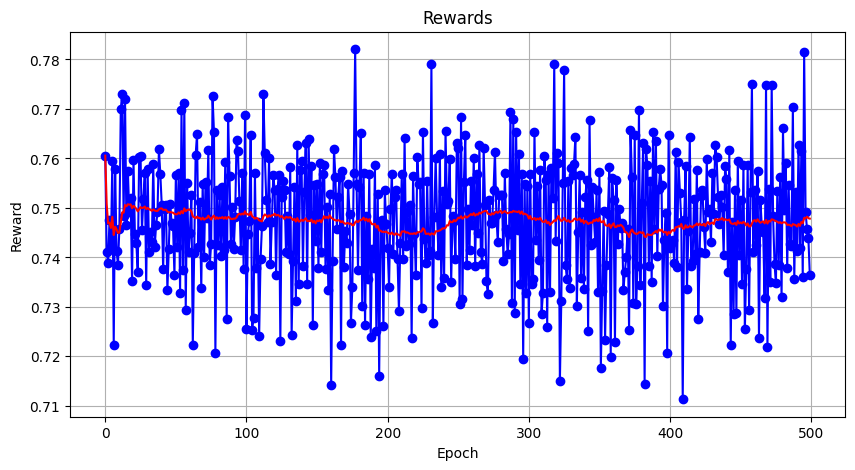

Best dev parameter list: ('gradient', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_6', 'color_bin_8', 'color_bin_9', 'rough', 'dominating_texture', 'texture_0', 'texture_2', 'texture_4', 'texture_5', 'texture_6', 'texture_9', 'rough_entropy', 'number_lengthy_objects', 'in_shape', 'roundness', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5')
Reward: 0.7820710973724883



In [14]:
hypothesized_features_crack = ["black", "black_thin", "rough", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", 
                               "rel_length", "darker"]

feature_selection_experiment("Crack", hypothesized_features_crack, epochs=500)

# Cross-classification evaluation

**Cross-classification evaluation using only focus features**

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7917694404777359, 
Recall: 0.8266494178525227,
F1: 0.7993495121341007

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 

C:\Users\koeni\AppData\Local\Temp\ipykernel_27028\979246621.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koeni\AppData\Local\Temp\ipykernel_27028\979246621.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koeni\AppData\Local\Temp\ipykernel_27028\979246621.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koeni\AppD

Accuracy: 0.3255785478143749
Recall (Micro): 0.3255785478143749
Recall (Macro): 0.4325326124463625
Recall (Weighted): 0.3255785478143749
F1 Score (Micro): 0.3255785478143749
F1 Score (Macro): 0.2675853488171771
F1 Score (Weighted): 0.3430111728271368


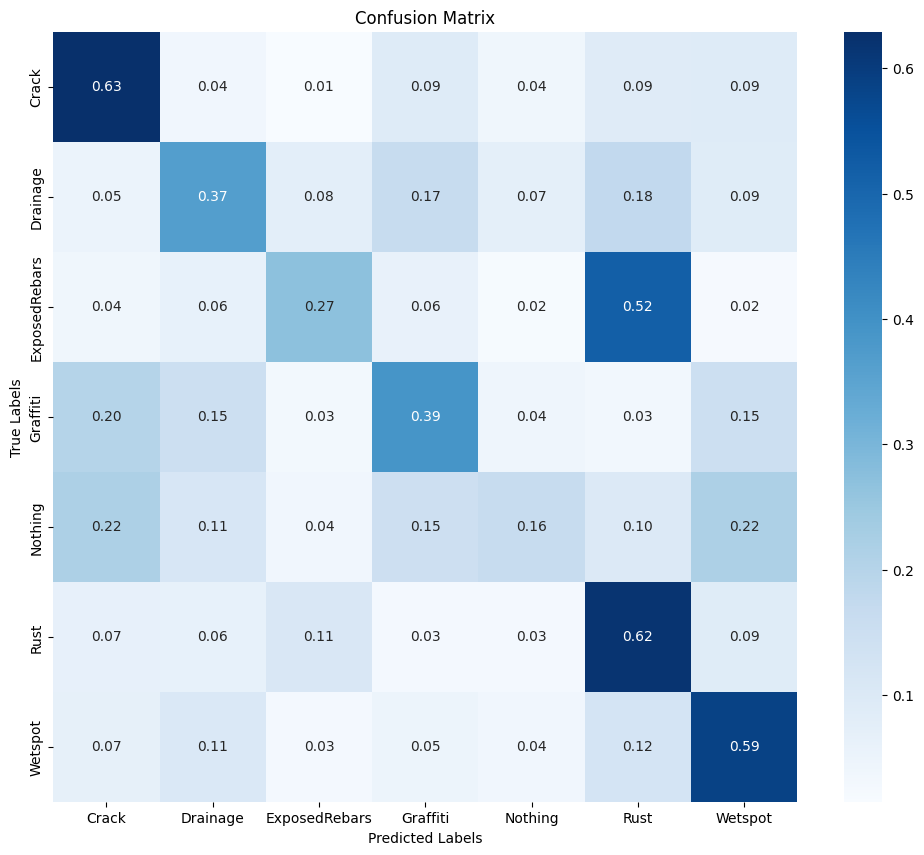

In [15]:
def cross_classification_evaluation_focus():
    
    focus_defects = ["Rust", "Drainage", "Graffiti", "ExposedRebars", "Wetspot", "Crack"]

    # Load best feature sets per defect class:
    individual_feature_sets = {}
    for defect in focus_defects:
        results = pd.read_csv(f"results/results_feature_selection_{defect}.csv")
        feature_set = [x for x in results.loc[0, "Best dev feature set"].strip("()").replace("'", "").split(", ")]
        individual_feature_sets[defect] = feature_set

    relevant_features_focus = {"Rust": individual_feature_sets["Rust"],
                               "Drainage": individual_feature_sets["Drainage"],
                               "Graffiti": individual_feature_sets["Graffiti"],
                               "ExposedRebars": individual_feature_sets["ExposedRebars"],
                               "Wetspot": individual_feature_sets["Wetspot"],
                               "Crack": individual_feature_sets["Crack"]
                               }

    # Perform cross-classification
    CrossClassificationModel(relevant_features_focus).evaluate_results("focus")

cross_classification_evaluation_focus()

**Cross-classification evaluation using all features**

In [16]:
def cross_classification_evaluation_all():

    all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                    "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                    "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                    "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                    "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                    "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
    
    focus_defects = ["Rust", "Drainage", "Graffiti", "ExposedRebars", "Wetspot", "Crack"]

    # Load best feature sets per defect class:
    individual_feature_sets = {}
    for defect in focus_defects:
        results = pd.read_csv(f"results/results_feature_selection_{defect}.csv")
        feature_set = [x for x in results.loc[0, "Best dev feature set"].strip("()").replace("'", "").split(", ")]
        individual_feature_sets[defect] = feature_set
    
    relevant_features_all = {"Rust": individual_feature_sets["Rust"],
                             "Drainage": individual_feature_sets["Drainage"],
                             "Graffiti": individual_feature_sets["Graffiti"],
                             "ExposedRebars": individual_feature_sets["ExposedRebars"],
                             "Wetspot": individual_feature_sets["Wetspot"],
                             "Crack": individual_feature_sets["Crack"],
                             "Weathering": all_features, 
                             "Rockpocket": all_features, 
                             "Spalling": all_features, 
                             "WConccor": all_features, 
                             "Cavity": all_features, 
                             "Efflorescence": all_features, 
                             "PEquipment": all_features, 
                             "Bearing": all_features, 
                             "Hollowareas": all_features, 
                             "JTape": all_features, 
                             "Restformwork": all_features, 
                             "ACrack": all_features, 
                             "EJoint": all_features
                             }

    # Perform cross-classification
    CrossClassificationModel(relevant_features_all).evaluate_results("all")

cross_classification_evaluation_all()

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7716277162771628, 
Recall: 0.766721044045677,
F1: 0.7714402954452195

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', '

c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3712501530549773
Recall (Micro): 0.3712501530549773
Recall (Macro): 0.28672618471824907
Recall (Weighted): 0.3712501530549773
F1 Score (Micro): 0.3712501530549773
F1 Score (Macro): 0.2474731311466219
F1 Score (Weighted): 0.3828881430348856
